### ***Importing Important libraries***

In [1]:
!pip install opendatasets

In [2]:
!pip install pandas

### *Downloading Data Sets*

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda")

Skipping, found downloaded files in "./animal-image-datasetdog-cat-and-panda" (use force=True to force download)


In [4]:
import os
import pandas
import cv2  # For image processing
import random
import matplotlib.pyplot as plt
from tqdm import tqdm  # For showing progress bars
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

In [5]:
data_dir = '/content/animal-image-datasetdog-cat-and-panda/animals/animals'

In [6]:
categories = os.listdir(data_dir)
print(categories)

['dogs', 'panda', 'cats']


In [7]:
train_data = []
for category in categories:
    category_path = os.path.join(data_dir, category)
    class_label = categories.index(category)
    # Loop through each image file in the category's directory
    for image_file in tqdm(os.listdir(category_path)):
        # Construct the full path to the image file
        image_path = os.path.join(category_path, image_file)
        # Read the image in grayscale
        image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Append the image data and the corresponding label to the training data list
        train_data.append([image_array, class_label])

# Now, `training_data` contains all the images and their labels

100%|██████████| 1000/1000 [00:01<00:00, 701.69it/s]


In [8]:
print(len(train_data))

3000


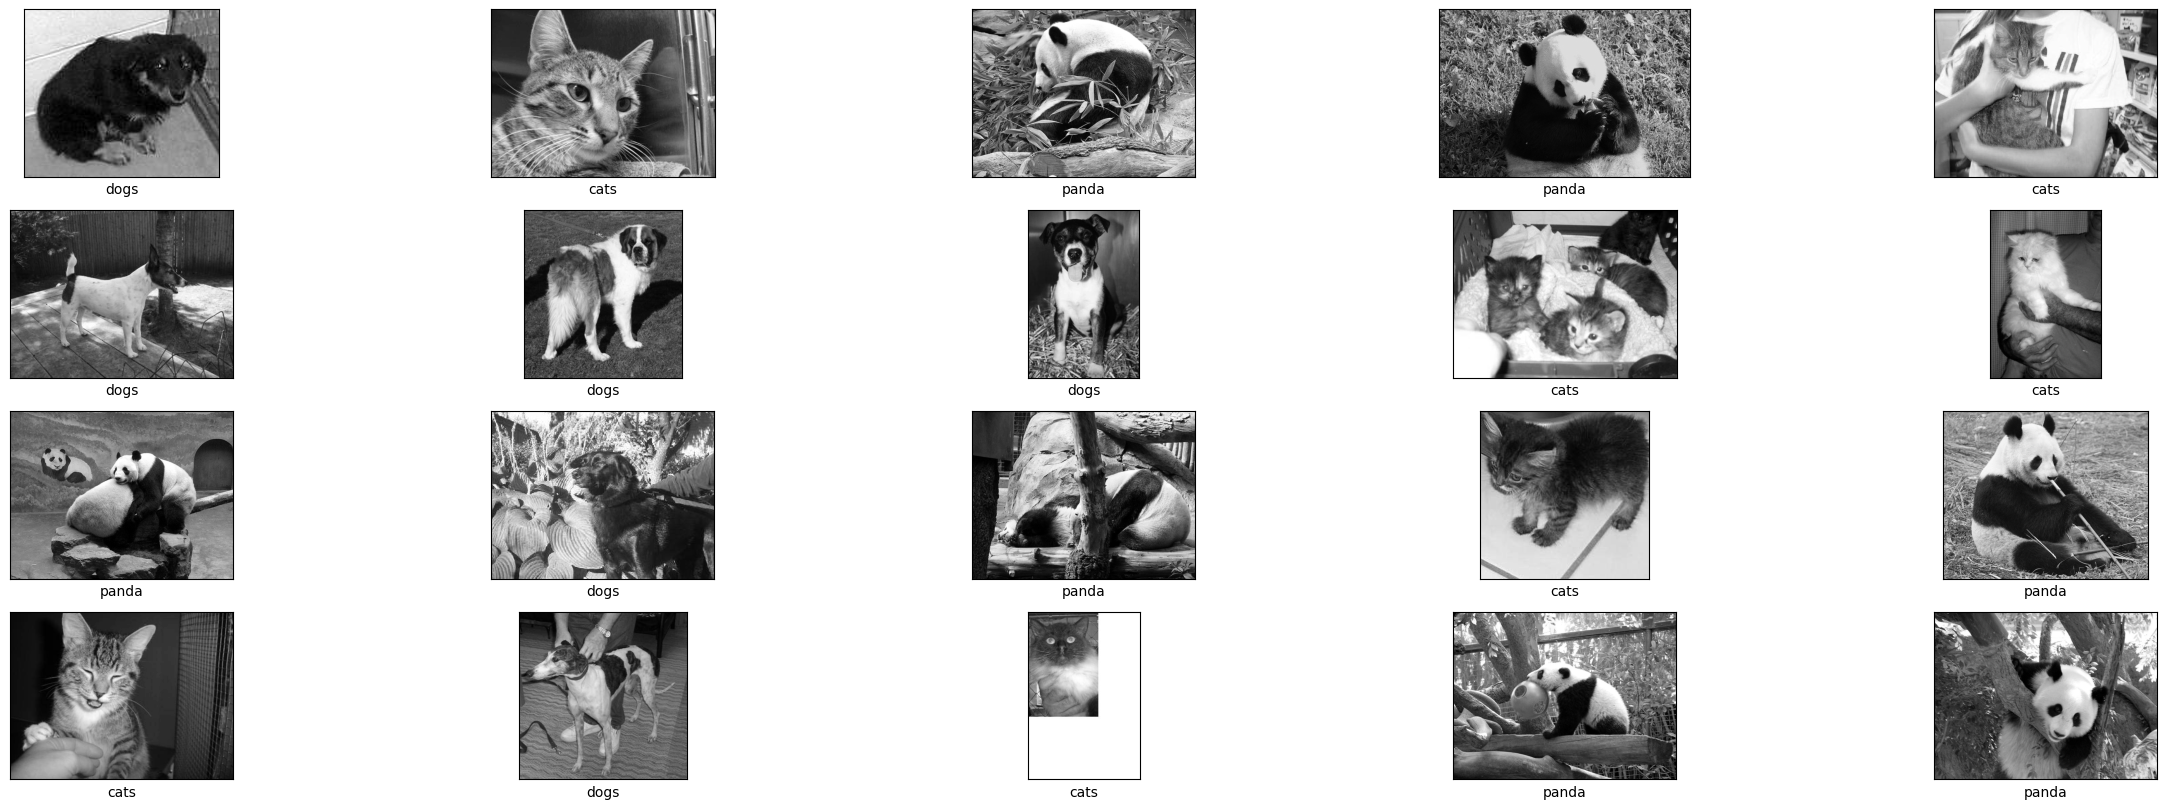

In [9]:
random.shuffle(train_data)
plt.figure(figsize=(30,10))
for i in range(20):
  plt.subplot(4,5,i+1)
  image = train_data[i][0]
  plt.imshow(train_data[i][0],cmap='gray') # Use training_data instead of train_data
  plt.xlabel(categories[train_data[i][1]]) # Use training_data instead of train_data
  plt.xticks([])
  plt.yticks([])

plt.show()

### *Training*

In [10]:
fold0 = train_data[0:600]
fold1 = train_data[600:1200]
fold2 = train_data[1200:1800]
fold3 = train_data[1800:2400]
fold4 = train_data[2400:3000]

In [11]:
print(len(fold0))
print(len(fold1))
print(len(fold2))
print(len(fold3))
print(len(fold4))

600
600
600
600
600


In [12]:
train_set = fold0+fold1+fold2+fold3
test_set = fold4

print(len(train_set))
print(len(test_set))

2400
600


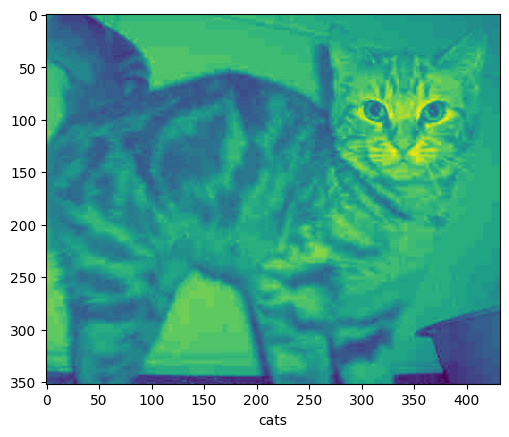

In [13]:
test_image = test_set[0][0]
plt.imshow(test_image) # Use test_image instead of image
plt.xlabel(categories[test_set[0][1]]) # Use a hardcoded index 0
plt.show()

In [14]:
# L1 and L2 distance functions with error handling for shape mismatch
def calculate_l1_distance(img1, img2):
    # Handle shape mismatch by resizing the second image to match the first one
    if img1.shape != img2.shape:
        img2 = np.resize(img2, img1.shape)
    return np.sum(np.abs(img1 - img2))  # L1 distance: sum of absolute differences

def calculate_l2_distance(img1, img2):
    # Handle shape mismatch by resizing the second image to match the first one
    if img1.shape != img2.shape:
        img2 = np.resize(img2, img1.shape)
    return np.sqrt(np.sum((img1 - img2) ** 2))  # L2 distance: Euclidean distance

# Functions to sort by L1 and L2 distances
def sort_by_l1(entry):
    return entry[2]["l1"]

def sort_by_l2(entry):
    return entry[2]["l2"]

# Set the top N neighbors to consider
top_n = 20

# Distance calculation function for L1 and L2
def calculate_distances(train_data, valid_data):
    l1_distances = []
    l2_distances = []

    for valid_sample in tqdm(valid_data, desc="Processing validation set"):
        neighbor_distances = []

        for train_sample in train_data:
            l1_distance = calculate_l1_distance(valid_sample[0], train_sample[0])
            l2_distance = calculate_l2_distance(valid_sample[0], train_sample[0])

            # Append label pairs and the distances
            neighbor_distances.append([valid_sample[1], train_sample[1], {"l1": l1_distance, "l2": l2_distance}])

        # Sort by L1 and L2 distances
        neighbor_distances.sort(key=sort_by_l1)
        l1_distances.append(neighbor_distances[:top_n])

        neighbor_distances.sort(key=sort_by_l2)
        l2_distances.append(neighbor_distances[:top_n])

    return [l1_distances, l2_distances]

# Range for k-values
k_max = 20

# Accuracy calculation based on distance results
def compute_accuracy(neighbors_distances, distance_metric="l1"):
    accuracy_by_k = []

    for k in range(1, k_max + 1):
        correct_predictions = 0

        for validation_result in neighbors_distances:
            # Get k nearest neighbors
            top_k_neighbors = validation_result[:k]

            # Count how many neighbors share the same label
            same_class_neighbors = [n for n in top_k_neighbors if n[0] == n[1]]
            num_same_class = len(same_class_neighbors)

            if k % 2 != 0:  # Odd k case
                # More than half of neighbors must be of the same class
                if num_same_class > (k // 2):
                    correct_predictions += 1
            else:  # Even k case
                different_class_neighbors = [n for n in top_k_neighbors if n[0] != n[1]]

                if num_same_class > len(different_class_neighbors):
                    correct_predictions += 1
                elif num_same_class == len(different_class_neighbors):
                    # Tie-breaker: Use the sum of distances
                    same_class_dist_sum = sum([n[2][distance_metric] for n in same_class_neighbors])
                    different_class_dist_sum = sum([n[2][distance_metric] for n in different_class_neighbors])

                    if same_class_dist_sum < different_class_dist_sum:
                        correct_predictions += 1

        # Calculate accuracy for this k
        accuracy_by_k.append(correct_predictions / len(neighbors_distances))

    return accuracy_by_k


In [15]:
# Perform 5-fold cross-validation by splitting data into training and validation sets
def cross_validation_split(folds, distance_calc_func):


    dist_by_fold = []

    # Iterate through each fold index to select validation and training sets
    for i in range(len(folds)):
        # Validation set is the current fold
        validation = folds[i]

        # Training set is all other folds concatenated together
        train = []
        for j in range(len(folds)):
            if j != i:
                train += folds[j]

        # Calculate distances between training and validation sets
        fold_distances = distance_calc_func(train, validation) # Use distance_calc_func instead of distance_calc

        # Append the result for this fold
        dist_by_fold.append(fold_distances)

    return dist_by_fold

# Assuming `fold0`, `fold1`, `fold2`, `fold3` and `fold4` are already defined folds (lists of data)
folds = [fold0, fold1, fold2, fold3, fold4]  # List of all folds

# Calculate the distances for each fold using cross-validation
dist_by_fold = cross_validation_split(folds, calculate_distances) # Pass calculate_distances as the function


Processing validation set: 100%|██████████| 600/600 [10:16<00:00,  1.03s/it]


In [16]:
len(dist_by_fold[0][0])

600

In [17]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = compute_accuracy(result[0], "l1") # Changed cal_accuracy to compute_accuracy
    l2_accuracy = compute_accuracy(result[1], "l2") # Changed cal_accuracy to compute_accuracy
    accuracies.append([l1_accuracy, l2_accuracy])

<ipython-input-18-f3daac97c338>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_l1 = cm.get_cmap('rainbow')
<ipython-input-18-f3daac97c338>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_l2 = cm.get_cmap('plasma')
<ipython-input-18-f3daac97c338>:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x_list, trend, fmt='-o', color='#003f5c', linewidth=3.5, capsize=8, marker='s', markersize=12, markerfacecolor='#003f5c', markeredgecolor='white', alpha=0.9)
<ipython-input-18-f3daac97c338>:57: UserWarning: marker is

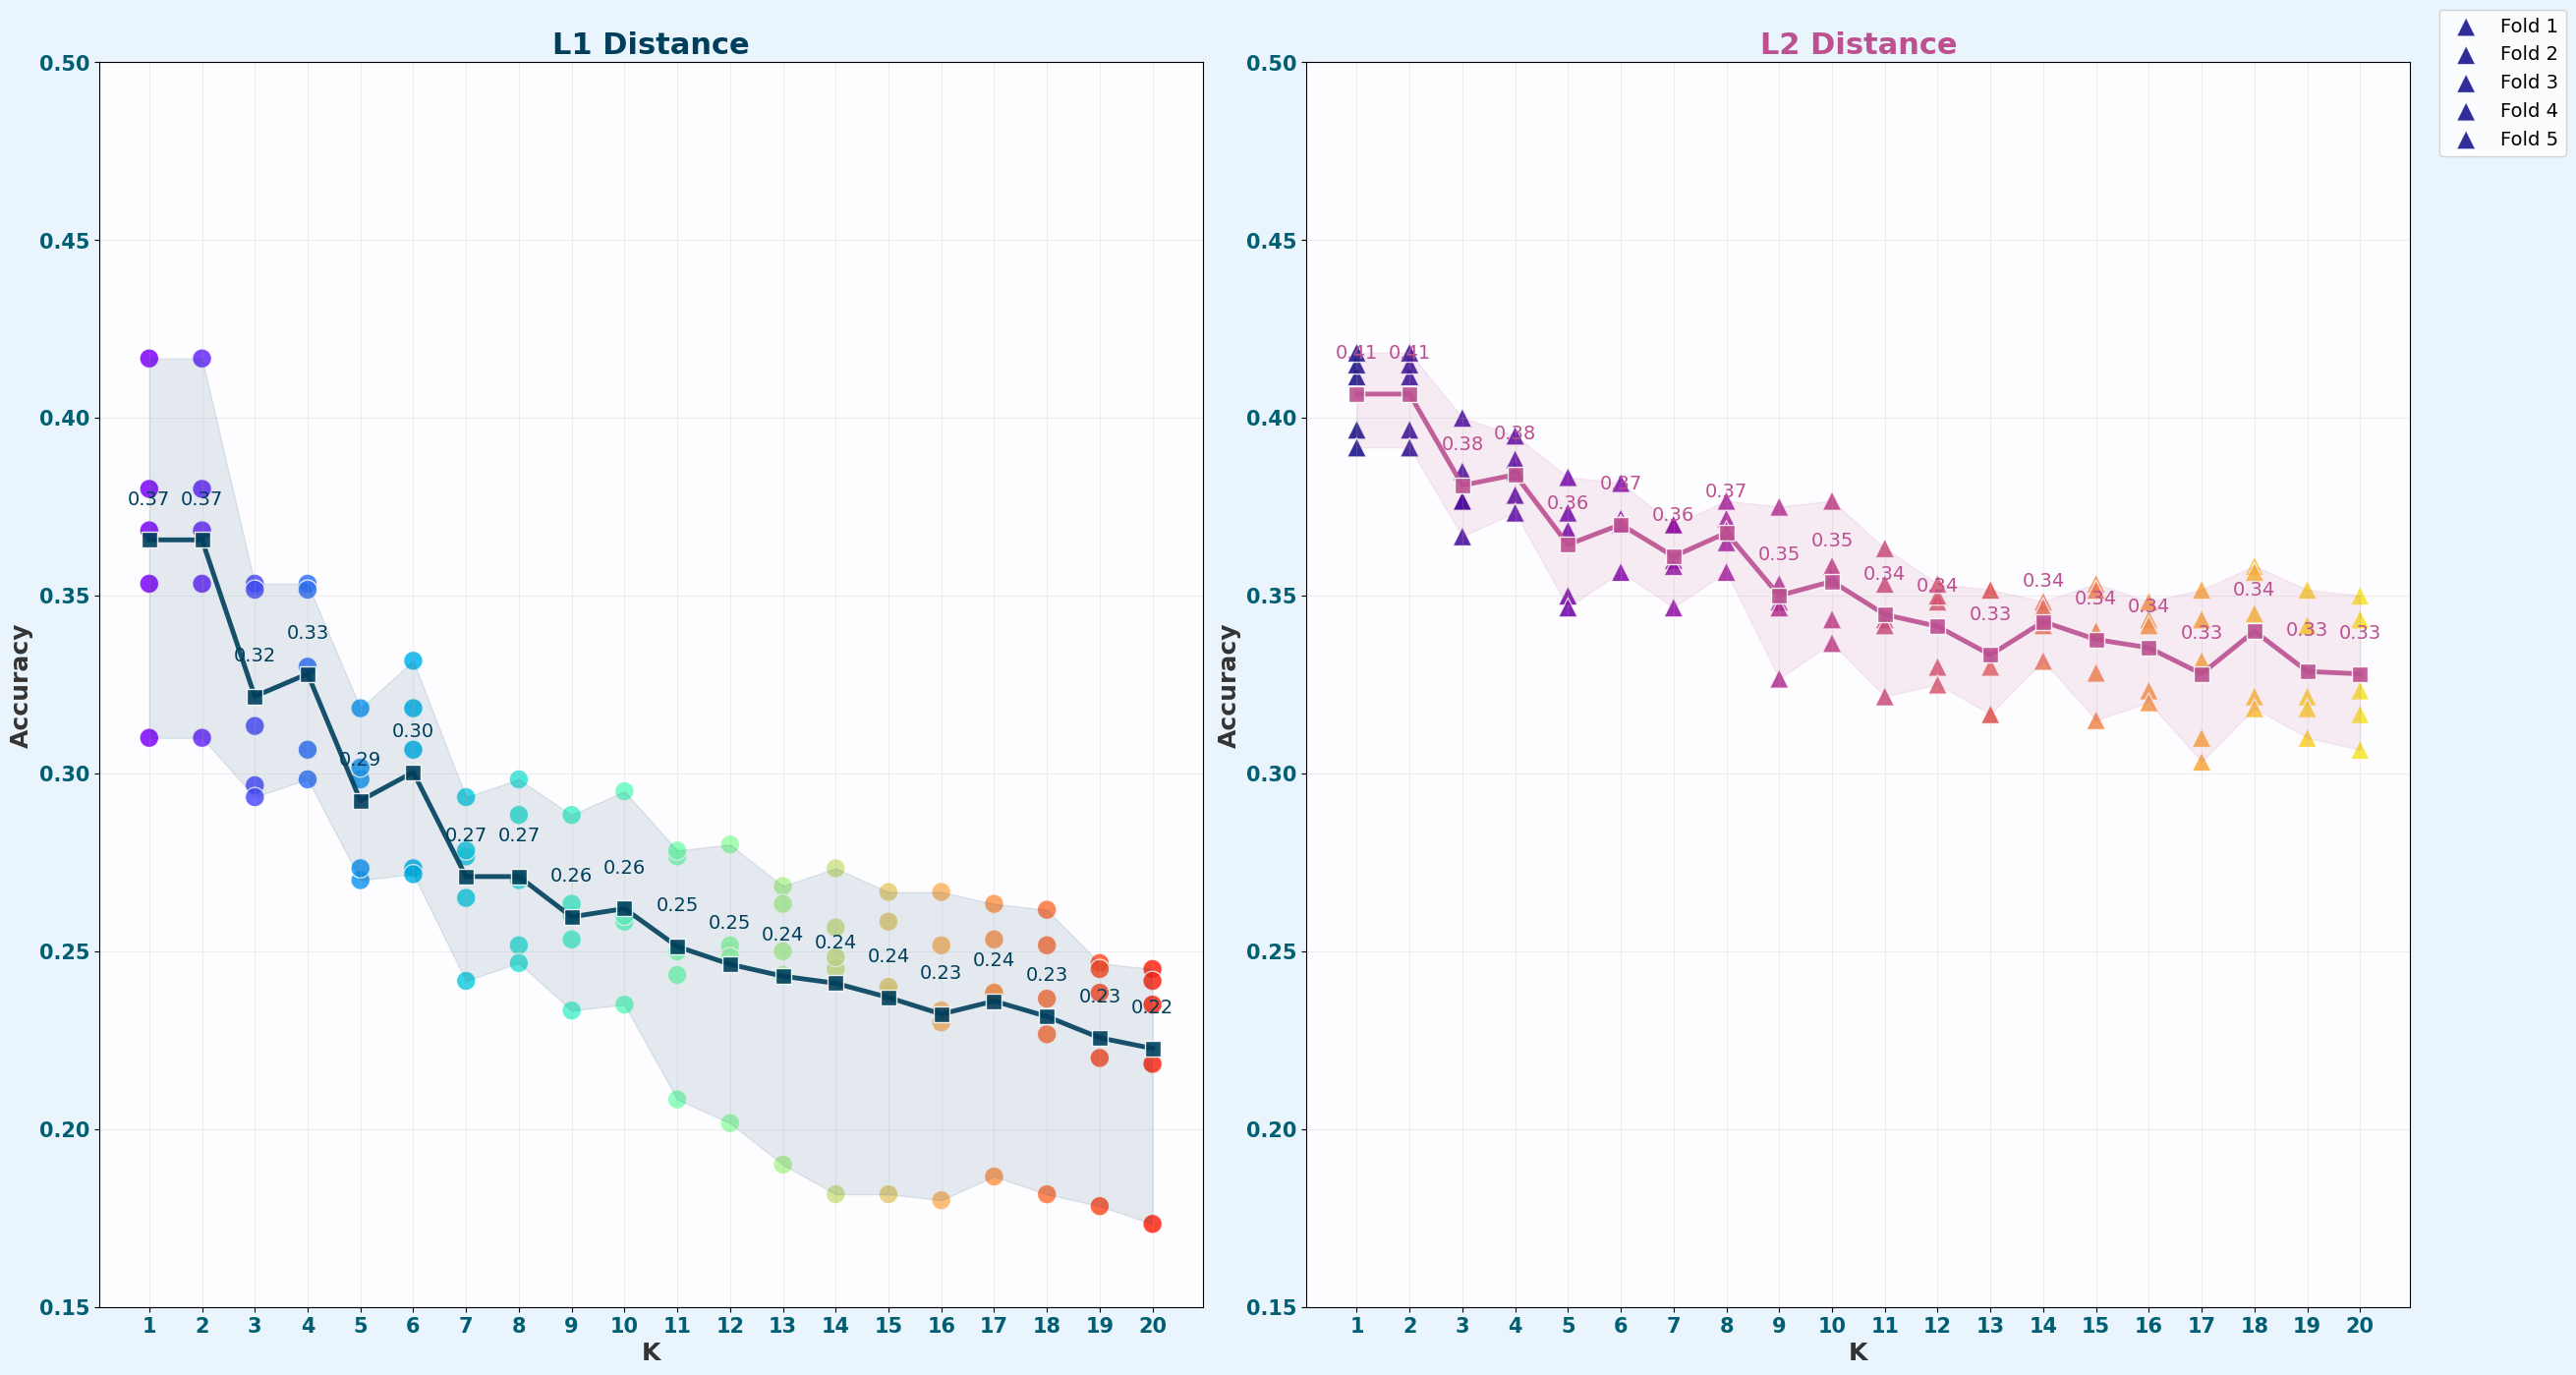

In [18]:
k_range = len(accuracies[0][0])  # Get the correct k_range from the accuracies data
x_list = list(range(1, k_range + 1))

# Create figure with a vibrant background and larger size
plt.figure(figsize=(26, 14), facecolor='#eaf4fc')

# Custom color maps for even more vibrant and varied scatter plots
cmap_l1 = cm.get_cmap('rainbow')
cmap_l2 = cm.get_cmap('plasma')
norm = Normalize(vmin=0, vmax=k_range)

# L1 Distance Plot with a colorful gradient and transparency
plt.subplot(1, 2, 1, facecolor='#fdfdff')
plt.title('L1 Distance', fontsize=22, fontweight='bold', color='#003f5c')
plt.xlabel('K', fontsize=18, fontweight='bold', color='#333333')
plt.ylabel('Accuracy', fontsize=18, fontweight='bold', color='#333333')

for i, fold in enumerate(accuracies):
    y_list = fold[0]
    colors = cmap_l1(norm(range(k_range)))  # Apply rainbow gradient colors for scatter points
    plt.scatter(x_list, y_list, c=colors, edgecolor='white', s=200, alpha=0.85, label=f'Fold {i+1}', marker='o')

# Compute and plot the trend line with a bold color and transparency
arr = [[fold[0][i] for fold in accuracies] for i in range(k_range)]
trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend, fmt='-o', color='#003f5c', linewidth=3.5, capsize=8, marker='s', markersize=12, markerfacecolor='#003f5c', markeredgecolor='white', alpha=0.9)

# Transparent bands around the trend to show spread of data
plt.fill_between(x_list, [np.min(a) for a in arr], [np.max(a) for a in arr], color='#003f5c', alpha=0.1)

# Enhanced annotations for the trend line
for i, val in enumerate(trend):
    plt.text(x_list[i], val + 0.01, f'{val:.2f}', ha='center', fontsize=14, color='#003f5c')

# Colorful ticks and gridlines
plt.xticks(x_list, fontsize=15, fontweight='bold', color='#005f73')
plt.yticks(fontsize=15, fontweight='bold', color='#005f73')
plt.ylim(0.15, 0.5)
plt.grid(True, linestyle='-', alpha=0.2)

# L2 Distance Plot with plasma color gradient
plt.subplot(1, 2, 2, facecolor='#fdfdff')
plt.title('L2 Distance', fontsize=22, fontweight='bold', color='#bc5090')
plt.xlabel('K', fontsize=18, fontweight='bold', color='#333333')
plt.ylabel('Accuracy', fontsize=18, fontweight='bold', color='#333333')

for i, fold in enumerate(accuracies):
    y_list = fold[1]
    colors = cmap_l2(norm(range(k_range)))  # Apply plasma gradient colors for scatter points
    plt.scatter(x_list, y_list, c=colors, edgecolor='white', s=200, alpha=0.85, label=f'Fold {i+1}', marker='^')

# Compute and plot the trend line with plasma color
arr = [[fold[1][i] for fold in accuracies] for i in range(k_range)]
trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend, fmt='-o', color='#bc5090', linewidth=3.5, capsize=8, marker='s', markersize=12, markerfacecolor='#bc5090', markeredgecolor='white', alpha=0.9)

# Transparent bands for L2 Distance trend spread
plt.fill_between(x_list, [np.min(a) for a in arr], [np.max(a) for a in arr], color='#bc5090', alpha=0.1)

# Annotations for the L2 trend line
for i, val in enumerate(trend):
    plt.text(x_list[i], val + 0.01, f'{val:.2f}', ha='center', fontsize=14, color='#bc5090')

# Colorful ticks and gridlines for L2 plot
plt.xticks(x_list, fontsize=15, fontweight='bold', color='#005f73')
plt.yticks(fontsize=15, fontweight='bold', color='#005f73')
plt.ylim(0.15, 0.5)
plt.grid(True, linestyle='-', alpha=0.2)

# Add a common legend for both subplots to explain the folds
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05), fontsize=14, fancybox=True)

plt.tight_layout()
plt.show()


### *Decision*

The analysis compares two distance metrics, L1 (Manhattan) and L2 (Euclidean), to evaluate the performance of a k-nearest neighbors (k-NN) model. The L1 distance shows accuracy starting at approximately 36% for \( K = 1 \) and gradually decreasing to around 22% at \( K = 20 \), with significant variation across different cross-validation folds for smaller \( K \) values. In contrast, the L2 distance demonstrates a higher initial accuracy of around 44% at \( K = 1 \) and a slower decline to about 27% at \( K = 20 \). The primary limitation of the k-NN model is its sensitivity to the choice of \( K \) and the distance metric, with accuracy typically decreasing as \( K \) increases, suggesting that more neighbors do not always improve performance. Additionally, the model's accuracy varies significantly across different data splits, indicating the importance of selecting an optimal \( K \). As a non-parametric algorithm, k-NN requires repeated distance calculations for each test point, which can be computationally intensive. To enhance performance, hyperparameter optimization could help identify the best \( K \), while experimenting with other distance metrics or data preprocessing methods like dimensionality reduction may improve accuracy. Ensemble methods combining different models or metrics could yield more robust results, and advanced models like neural networks could further improve accuracy and reduce computation time by retaining learned parameters.

### *Prediction*

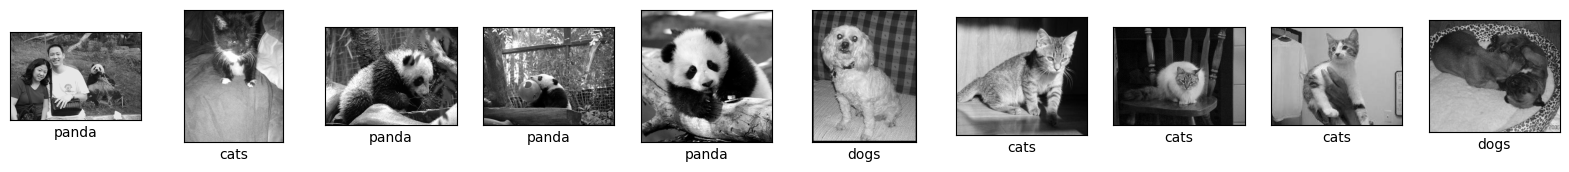

In [19]:
random.shuffle(train_data)
test_images = []

plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(5, 10, i+1)
    image = train_data[i][0]
    # Check if the image is already grayscale
    if len(image.shape) == 2:  # Grayscale images have shape (height, width)
        image_gray = image
    else:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    test_images.append([image_gray, categories[train_data[i][1]]])
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(categories[train_data[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 19:
        break

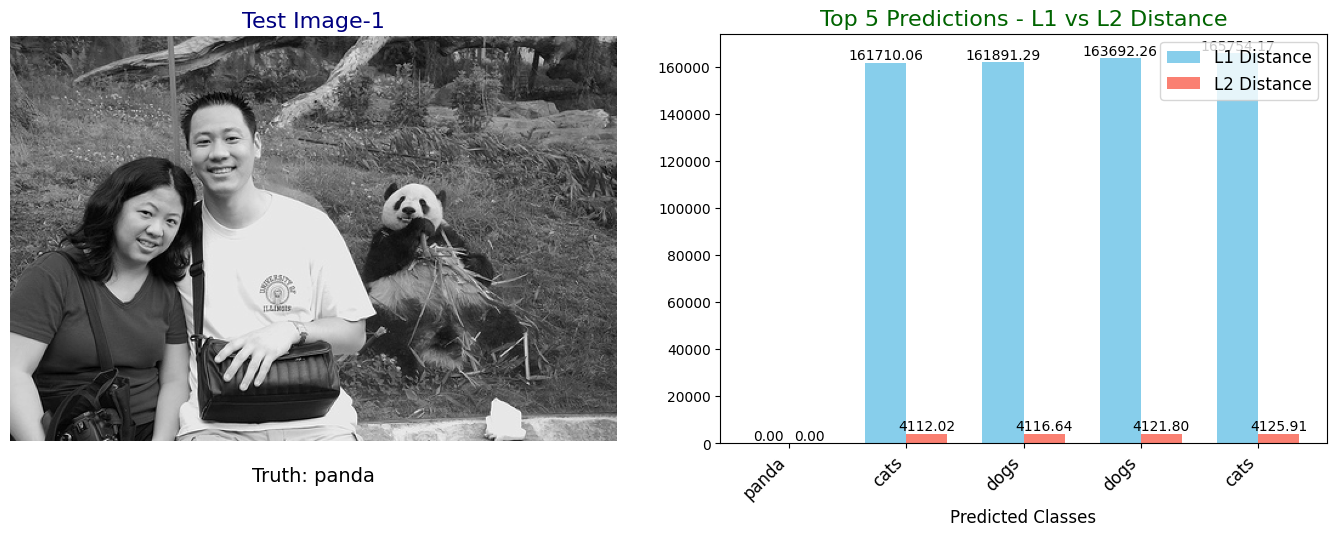

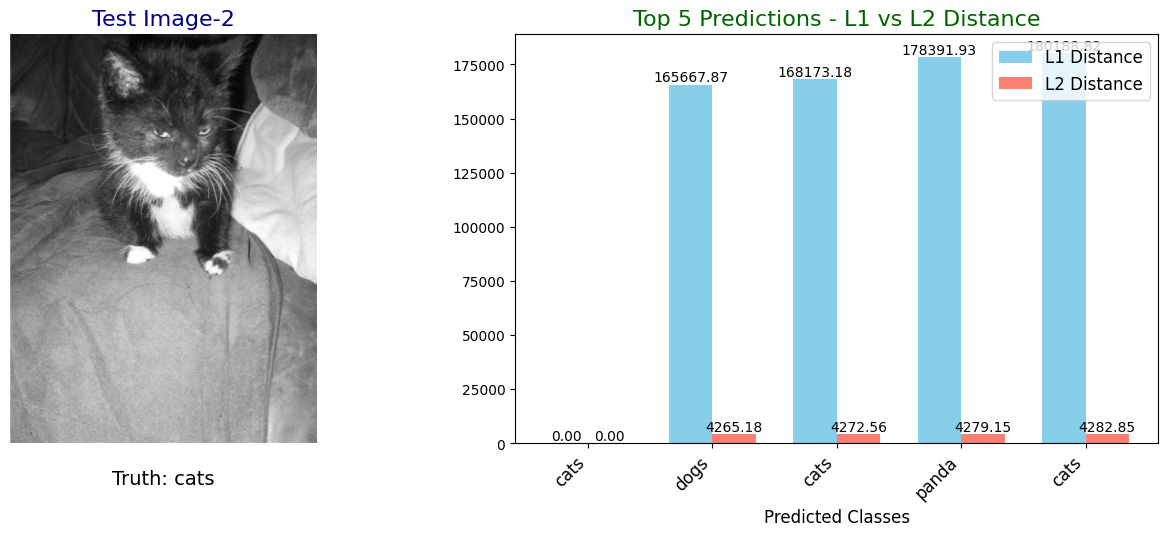

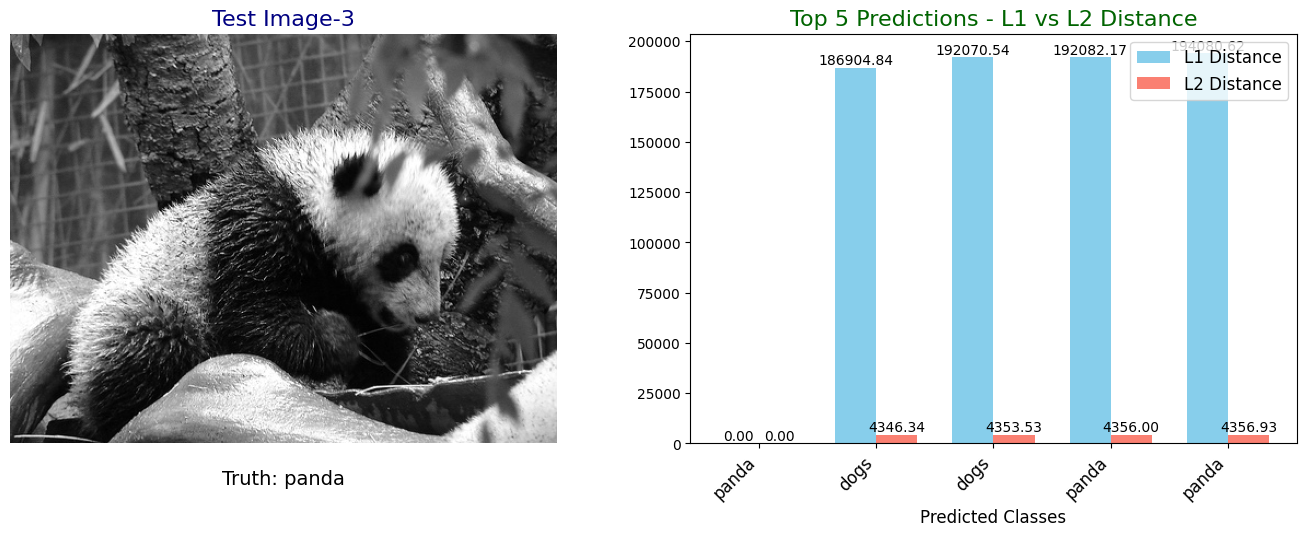

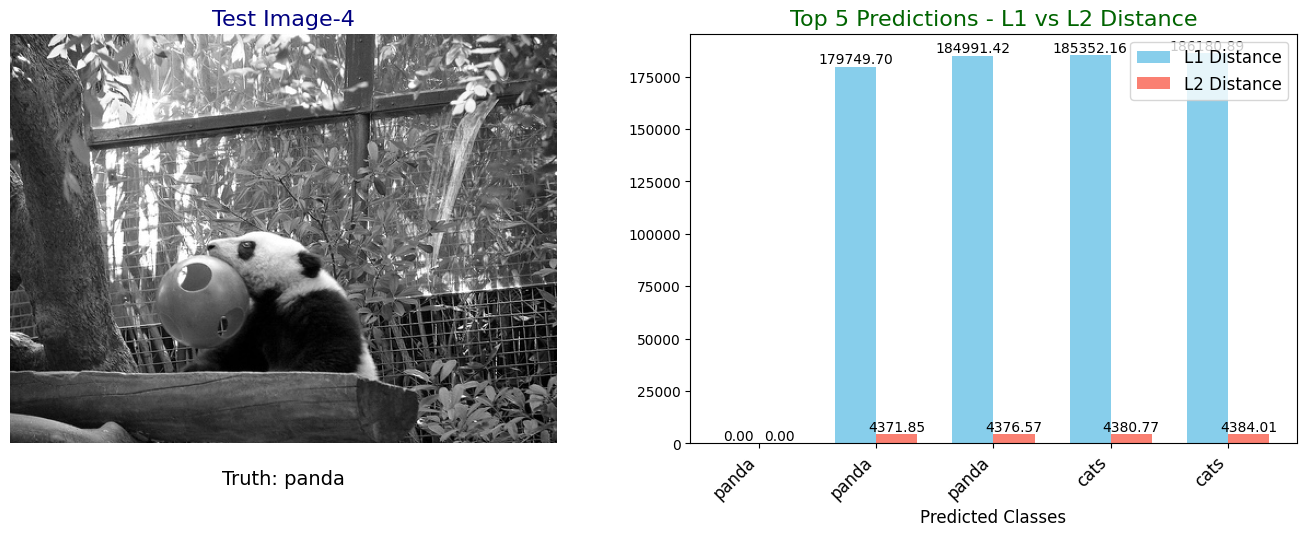

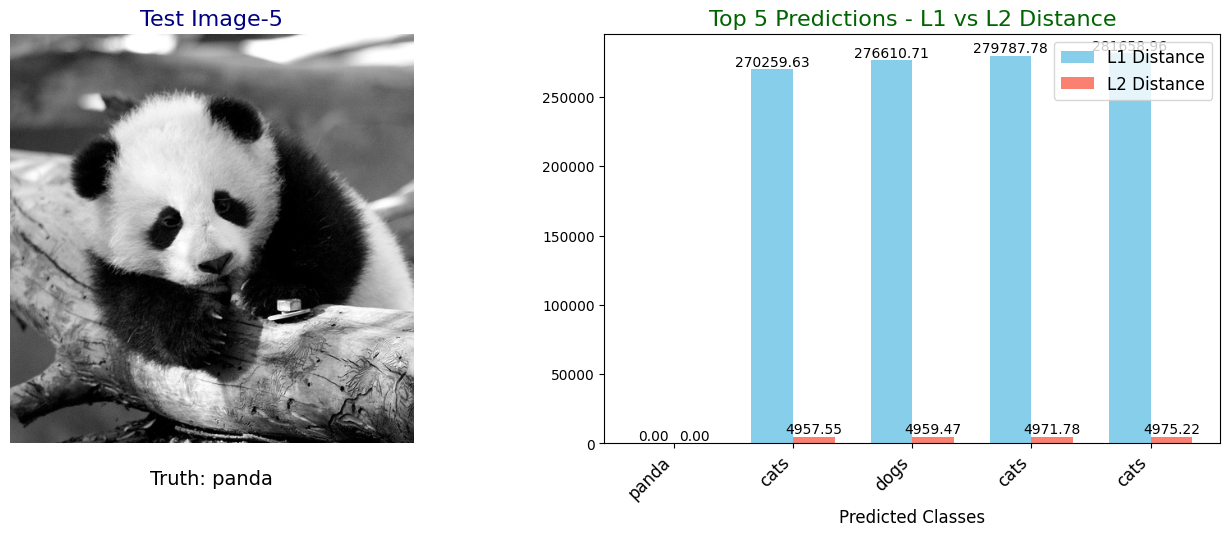

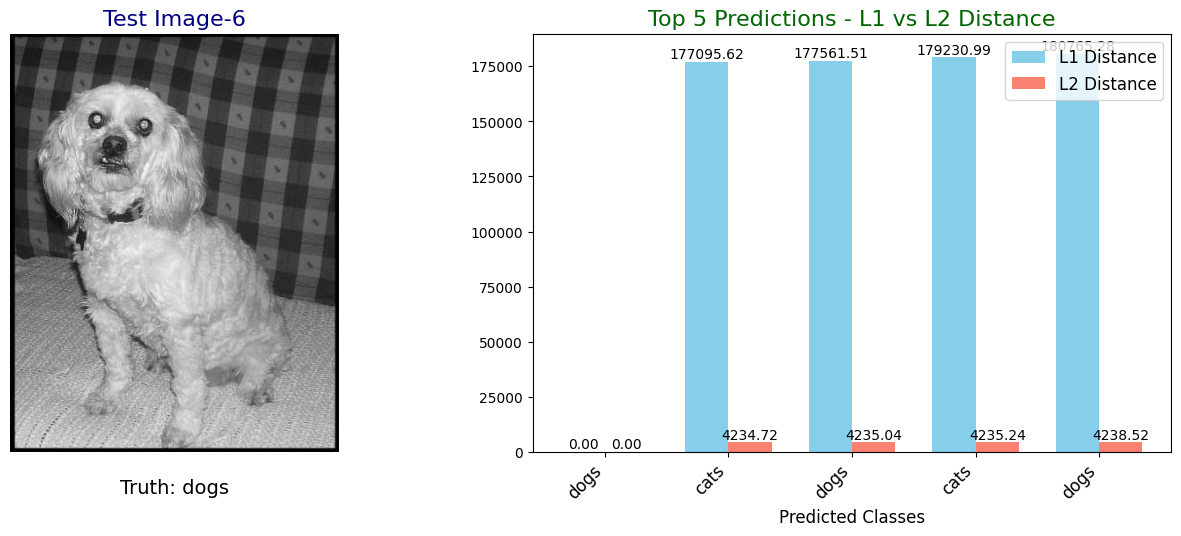

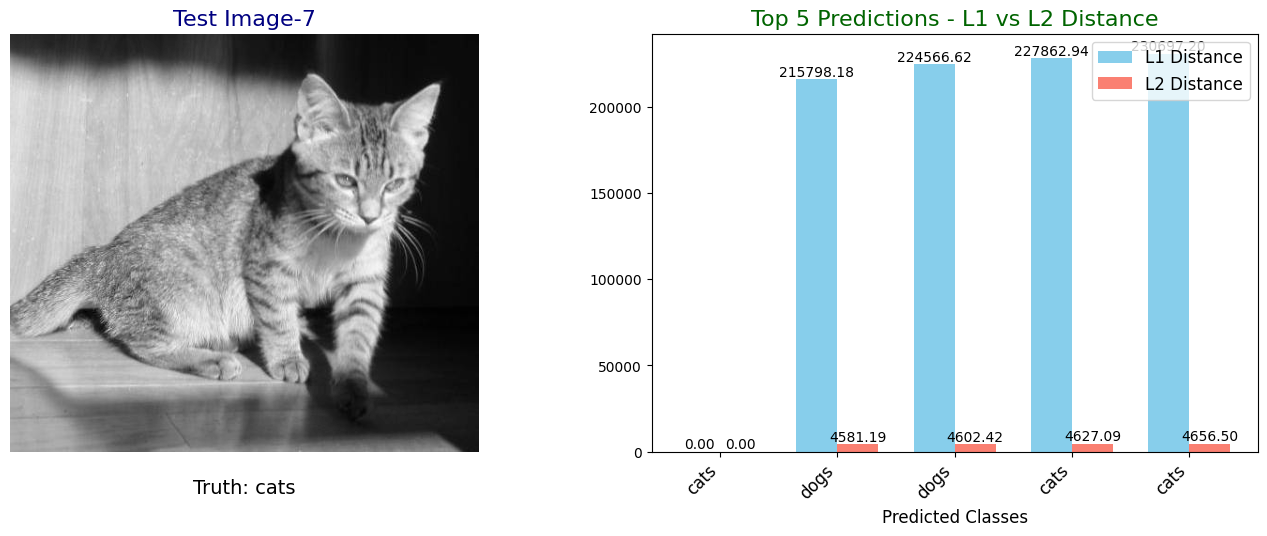

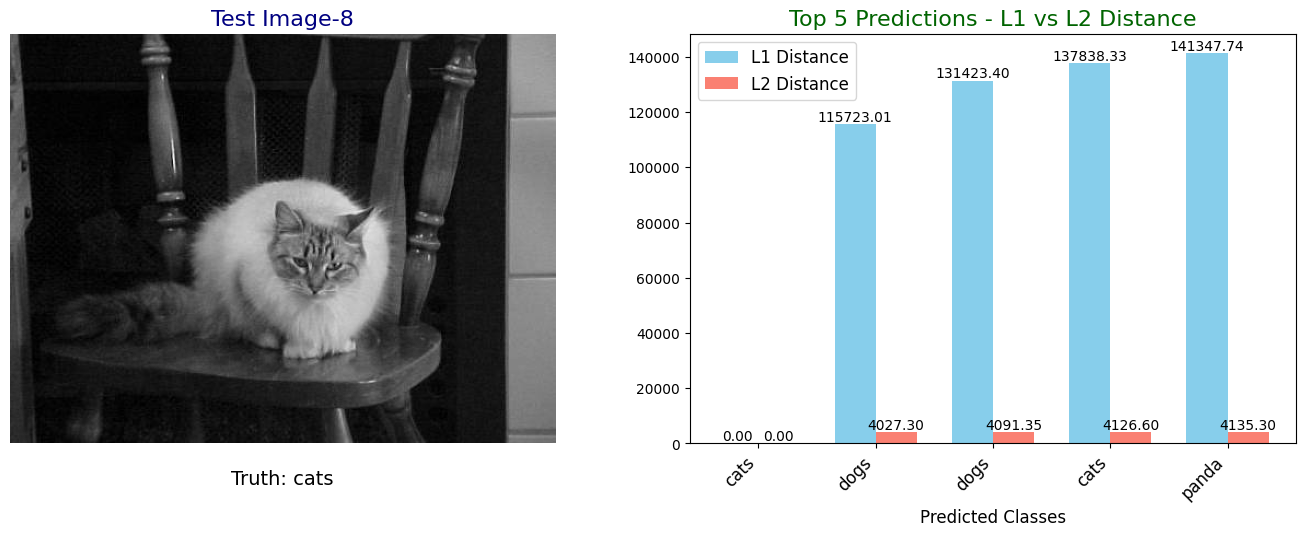

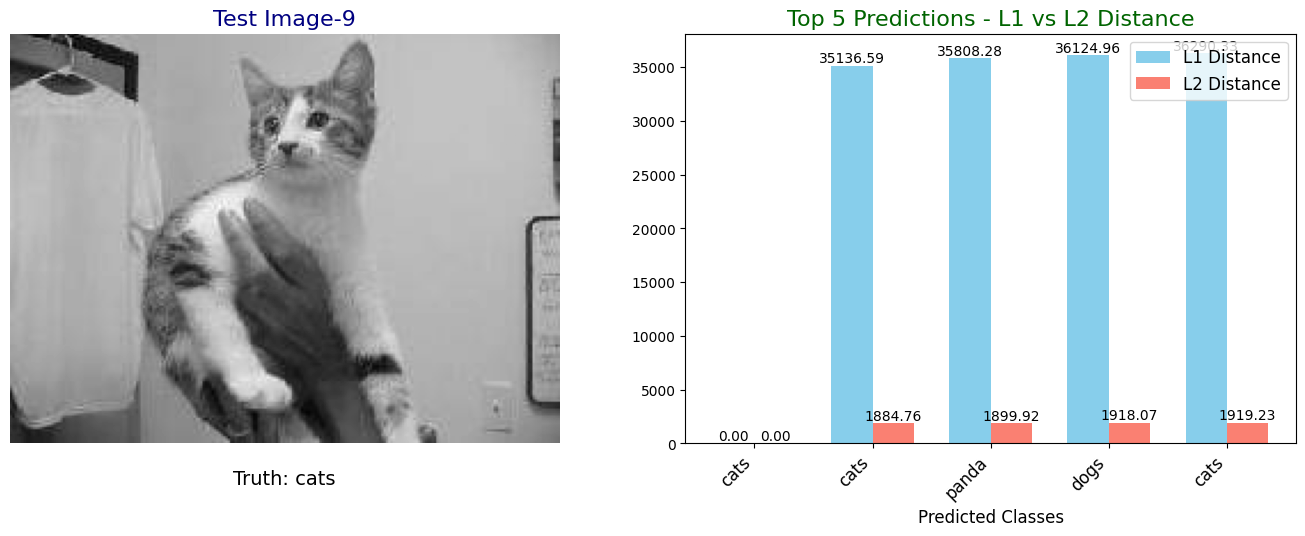

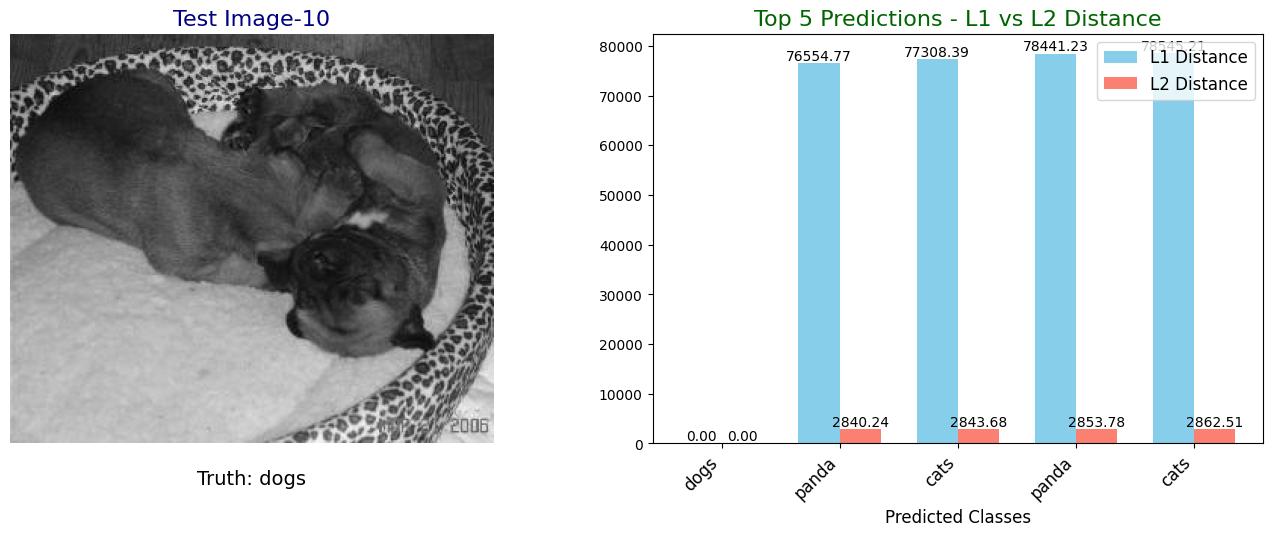

In [20]:
import numpy as np

for i, test_image_gray in enumerate(test_images):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Larger size for better visuals

    # Display the test image on the left subplot
    axes[0].imshow(test_image_gray[0], cmap="gray")
    axes[0].axis('off')  # Hide axes for the image

    # Add the title "Truth: [category]" below the image, aligned at the center
    true_label = categories[train_data[i][1]]
    axes[0].set_title(f"Test Image-{i+1}", fontsize=16, color="navy")
    axes[0].text(0.5, -0.1, f'Truth: {true_label}', size=14, ha="center", transform=axes[0].transAxes)  # Add the label below the image

    # Calculate L1 and L2 distances and predictions (as in previous example)
    distances1 = []
    distances2 = []

    for train_image, class_num in train_data:
        # Convert the image to grayscale if necessary
        if len(train_image.shape) == 2:
            train_image_gray = train_image
        else:
            train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)

        # L1 distance
        dist1 = calculate_l1_distance(test_image_gray[0], train_image_gray)
        distances1.append((dist1, class_num))

        # L2 distance
        dist2 = calculate_l2_distance(test_image_gray[0], train_image_gray)
        distances2.append((dist2, class_num))

    # Sort distances for top 5 predictions
    distances1.sort(key=lambda x: x[0])
    distances2.sort(key=lambda x: x[0])

    # Extract top 5 predictions and distances
    top5_classes = [categories[distances1[j][1]] for j in range(5)]
    l1_distances = [distances1[j][0] / 100 for j in range(5)]  # Scale L1 distance
    l2_distances = [distances2[j][0] for j in range(5)]

    # Plot the bar chart for top 5 predictions
    x = np.arange(5)  # X-axis labels (indices for top 5 classes)
    width = 0.35  # Bar width

    bars1 = axes[1].bar(x - width/2, l1_distances, width, label='L1 Distance', color='skyblue')
    bars2 = axes[1].bar(x + width/2, l2_distances, width, label='L2 Distance', color='salmon')

    # Add labels and title to the bar chart
    axes[1].set_xlabel('Predicted Classes', fontsize=12)
    axes[1].set_title('Top 5 Predictions - L1 vs L2 Distance', fontsize=16, color="darkgreen")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(top5_classes, rotation=45, ha='right', fontsize=12)  # Rotate for better readability
    axes[1].legend(fontsize=12)  # Add legend

    # Display the L1 distance values above each L1 bar
    for bar in bars1:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    # Display the L2 distance values above each L2 bar
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout(pad=3)  # Adjust layout for better spacing
    plt.show()
